## Import necessary packages tutorial

In [1]:
import renom as rm
from renom.utility.initializer import GlorotNormal, GlorotUniform
import gym

/Users/thakur/ReNom/renom/cuda/__init__.py:12: UserWarning: Couldn't find cuda modules. No module named 'renom.cuda.cuda_base'
  warnings.warn("Couldn't find cuda modules. %s" % e)
/Users/thakur/ReNom/renom/cuda/__init__.py:29: UserWarning: Couldn't find cuda modules.
  warnings.warn("Couldn't find cuda modules.")


## Deifne the environment tutorial

In [2]:
env = gym.make('Pendulum-v0')

[2018-03-16 14:25:16,849] Making new env: Pendulum-v0


## Define the actor network tutorial

In [3]:
class Actor(rm.Model):
    
    '''Here considered 3-layer network (excluding input layer). Feel free to change the network depth 
    and check the results. The output-layer number of nuerons are equal to number of actions.
    In the example of OpenAI Gym's Pendlum-v0 environment number of actions are 1.'''
    
    def __init__(self, env, layer_size):
        self._layers = []
        self.env = env
        self._l1 = rm.Dense(layer_size[0], initializer=GlorotUniform())
        self._l2 = rm.Dense(layer_size[1], initializer=GlorotUniform())
        self._l3 = rm.Dense(self.env.action_space.shape[0], initializer=GlorotUniform())
        self._layers = [self._l1, self._l2, self._l3]
    
    def forward(self, x):
        '''Neural Network inputs are state information, outputs are actions. '''
        h1 = rm.relu(self._l1(x))
        h2 = rm.relu(self._l2(h1))
        h3 = rm.tanh(self._l3(h2)) 
        #h = self._l3(h2)
        h = h3*self.env.action_space.high[0]
        return h
    
    def weigiht_decay(self):
        '''To minimize over fitting considered L2-norm (it is an optional)'''
        weight_decay = 0
        for i in range(len(self._layers)):
            weight_decay += rm.sum(self._layers[i].params.w**2)
        return weight_decay


# Define the Critic network tutorial

In [4]:
class Critic(rm.Model):
    '''Here considered a 3-layer network (input layer, hidden layer-1, hidden layer-2, output layer)
        At input-layer state information, 2nd-hidden layer actions are applied, last layer has a single neuron'''
    def __init__(self, env, layer_size):        
        self._layers = []
        self.env = env
        self._l1 = rm.Dense(layer_size[0], initializer=GlorotUniform())
        self._l2 = rm.Dense(layer_size[1], initializer=GlorotUniform())
        self._l3 = rm.Dense(1, initializer=GlorotUniform())
        self._layers = [self._l1, self._l2, self._l3]
  
    def forward(self, x, action):
        '''Q(s,a) calculation for a given (state, action) pair'''
        h1 = rm.relu(self._l1(x))
        h2 = rm.relu(self._l2(rm.concat(h1,action))) # actions are applied at 2nd hidden layer
        h = self._l3(h2)        
        return h
    
    def weigiht_decay(self):
        '''To minimize over fitting considered L2-norm (it is an optional)'''
        weight_decay = 0
        for i in range(len(self._layers)):
            weight_decay += rm.sum(self._layers[i].params.w**2)
        return weight_decay

## Instantiating the actor & ciritic networks 

In [5]:
from renom.algorithm.reinforcement.ddpg import DDPG
layer_size = [400, 300] # two-hidden layers dimension
actor_network = Actor(env=env,layer_size=layer_size)
critic_network = Critic(env=env, layer_size=layer_size)
target_actor_network = Actor(env=env,layer_size=layer_size)
target_critic_network = Critic(env=env, layer_size=layer_size)

## Instantiating the DDPG class

In [6]:
ddpg = DDPG(env=env, actor_network=actor_network, critic_network=critic_network, \
            target_actor_network=target_actor_network, target_critic_network=target_critic_network)
# ddpg = DDPG(env=env) # for default

## Training 

In [7]:
[reward_list, loss_list]=ddpg.train(num_episodes=5)

episode: 000 Total reward:-1529.52 avg loss:4.1651: 100%|██████████| 200/200 [00:04<00:00, 49.27it/s]
episode: 001 Total reward:-1587.04 avg loss:0.9041: 100%|██████████| 200/200 [00:05<00:00, 33.57it/s]
episode: 002 Total reward:-1058.68 avg loss:0.4037: 100%|██████████| 200/200 [00:06<00:00, 32.90it/s]
episode: 003 Total reward:-1345.63 avg loss:0.3058: 100%|██████████| 200/200 [00:05<00:00, 35.09it/s]
episode: 004 Total reward:-1331.44 avg loss:0.2513: 100%|██████████| 200/200 [00:05<00:00, 35.60it/s]


## Testing

In [8]:
test_reward_list = ddpg.test(render=False,episodes=5)

episode: 004 Total reward:-1333.10: 100%|██████████| 200/200 [00:00<00:00, 226.68it/s]    


## Plotting the test result

Text(0,0.5,'Total Rewards per Episode')

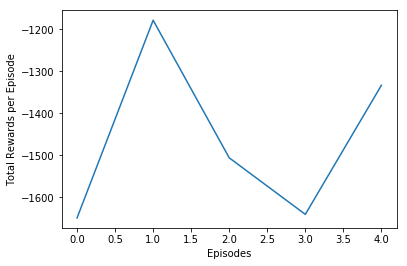

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(test_reward_list)
plt.xlabel("Episodes")
plt.ylabel("Total Rewards per Episode")